In [1]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test_round2.csv
./data/train_round2.csv
./data/graph_round2.csv
./data/test.csv
./data/graph.csv
./data/submission_round2.csv
./data/submission.csv
./data/train.csv


**Change the `data_dir` to the correct data set parent directory**

In [3]:
data_dir = "data"

In [4]:
train_data_path = os.path.join(data_dir, "train_round2.csv")
test_data_path  = os.path.join(data_dir, "test_round2.csv")
graph_data_path = os.path.join(data_dir, "graph_round2.csv")

**Load data sheets to `pandas.DataFrame()`**

In [5]:
train_data = pd.read_csv(train_data_path)
# train_data = train_data.loc[:,'ID':'Active']

train_data.describe()

,ID,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
count,11250.000000,1.125000e+04,11250.000000,9419.000000,1.125000e+04,11250.000000,1.055000e+04,5047.000000,10550.000000,11250.000000,5047.000000
mean,5624.500000,9.583625e+04,3057.178311,40276.189086,5.907248e+04,1357.938709,1.161268e+06,6250.044185,3.300561,20085.845676,12.197144
std,3247.739599,1.516621e+05,5377.615328,81746.843553,1.243728e+05,1199.193935,2.031813e+06,13880.694435,2.039538,19319.956138,5.255183
min,0.000000,2.700000e+02,0.000000,0.000000,-9.890000e+02,32.771004,5.459000e+03,10.000000,0.000000,460.300152,2.302896
25%,2812.250000,1.054600e+04,273.000000,3030.500000,4.599500e+03,374.587118,1.579640e+05,595.000000,1.708176,5761.788808,8.387037
50%,5624.500000,4.175800e+04,1031.000000,10376.000000,1.579100e+04,1045.850447,4.901655e+05,2068.000000,2.802207,15172.226199,11.351161
75%,8436.750000,1.174958e+05,3387.000000,48028.000000,5.289675e+04,2046.182244,1.247765e+06,6134.500000,4.425834,27209.961598,15.396088
max,11249.000000,1.153529e+06,34319.000000,913796.000000,1.095798e+06,9537.675412,1.956515e+07,89995.000000,9.741481,134755.702292,38.501190


## Now let's visualize some <br>S.H.I.T. (Scatterplots and Histograms that Interpret the Trend)

In [6]:
# First, we will get the total confirmed/deaths of each state
states = list(np.unique(train_data['Province_State']))
collected = ['Confirmed', 'Deaths', 'People_Tested']
states_data = dict.fromkeys(states, None)
state_scaler = {}

for s in states:
    df_filter = train_data['Province_State'] == s
    state_df = train_data[df_filter]
    states_data[s] = state_df.drop(['Date','Deaths','Active','ID', 'Province_State', 'Incident_Rate', 'Recovered', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'], 1)
    save_columns = states_data[s].columns
    state_scaler[s] = StandardScaler()
#     state_scaler[s] = MinMaxScaler()
    states_data[s] = state_scaler[s].fit_transform(states_data[s])
    states_data[s] = pd.DataFrame(states_data[s], columns=save_columns)
    
    

In [7]:
states_data['California']

,Confirmed
0,-1.364196
1,-1.360897
2,-1.356760
3,-1.352899
4,-1.350021
...,...
220,1.658917
221,1.697050
222,1.733562
223,1.779101


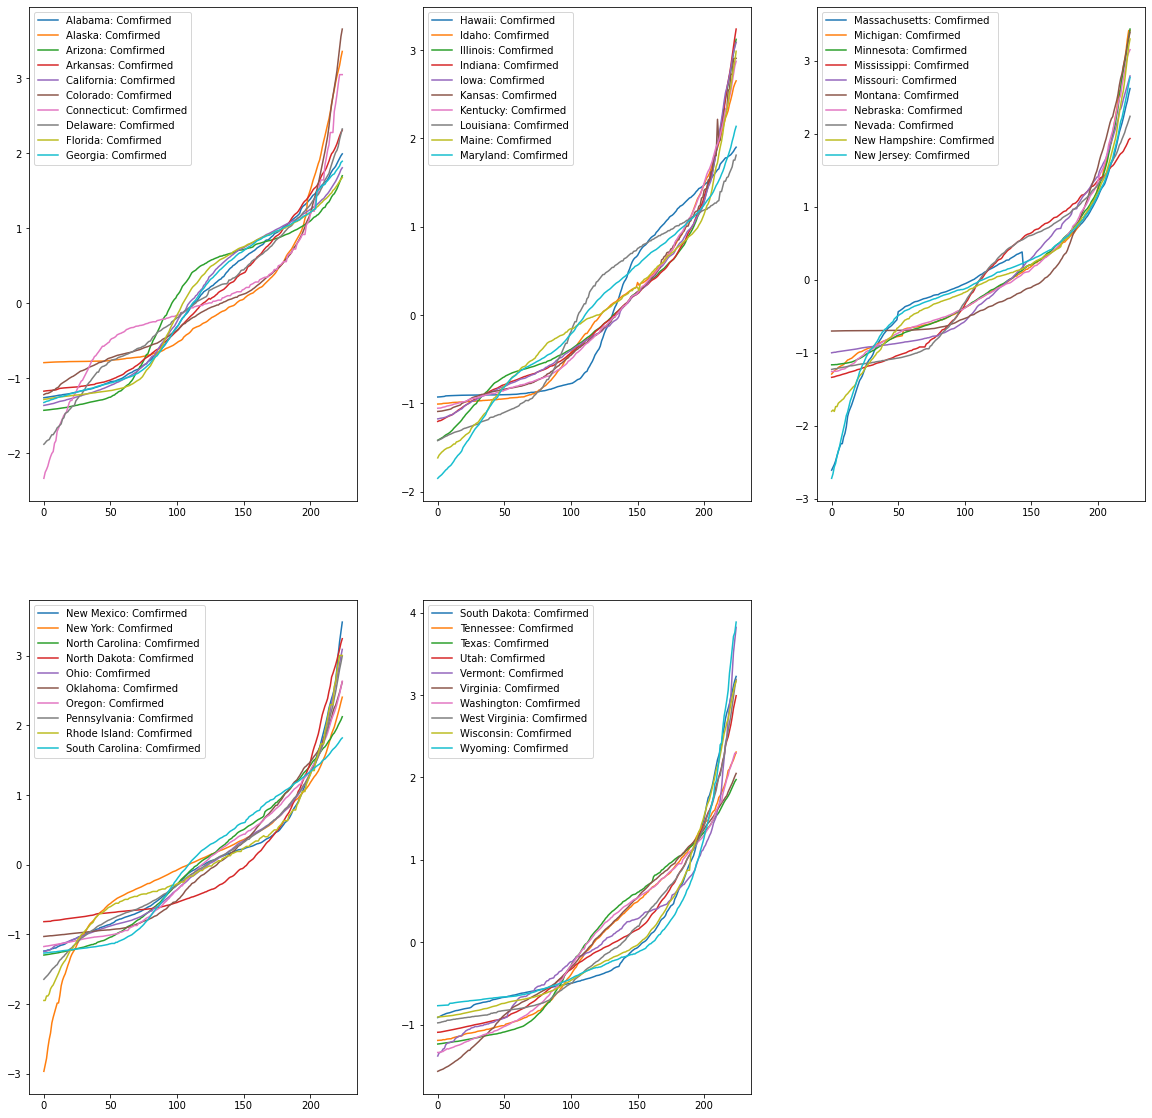

In [8]:
num_states = len(states_data.keys())
state_count = 1
figure_count = 1;
plt.figure(figsize=(20, 20))
for state in states_data.keys():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(states_data[state].Confirmed.values, label=f"{state}: Comfirmed")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1
        
# plt.subplot(1,2,2)
# plt.plot(states_data['California'].Deaths.values, color='blue', label='Deaths')
# plt.legend(loc='best')


## Create Cross-validation Datasets

In [9]:
test_percentage = 1
validate_percentage = 0
state_train_data = {}
state_validate_data = {}

for state in states_data.keys():
    state_data_size = states_data[state].shape
    state_test_size = math.floor(state_data_size[0]*test_percentage)
    state_train_data[state] = states_data[state][:state_test_size]
    state_validate_data[state] = states_data[state][state_test_size:]

## Visualize the Trend of One State

AttributeError: 'DataFrame' object has no attribute 'Deaths'

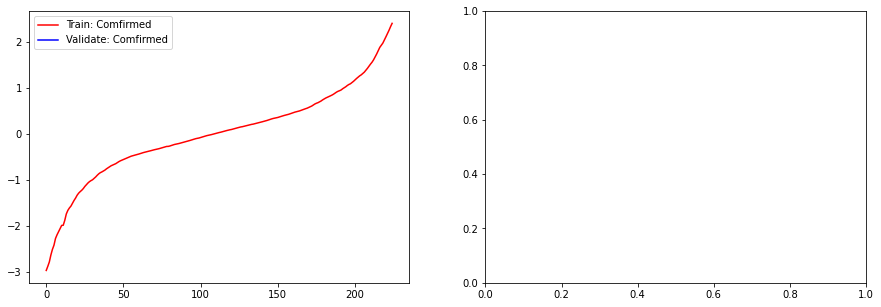

In [10]:
current_state = 'New York'
num_state_train = state_train_data[current_state].shape[0]
num_state_validate = state_validate_data[current_state].shape[0]
validate_range = np.arange(num_state_train, num_state_train+num_state_validate)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data[current_state].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(validate_range, state_validate_data[current_state].Confirmed.values, color='blue', label='Validate: Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data[current_state].Deaths.values, color='blue', label='Train: Deaths')
plt.plot(validate_range, state_validate_data[current_state].Deaths.values, color='red', label='Validate: Deaths')
plt.legend(loc='best')

## Train a RNN Model with LSTM

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model


# test model for CA
data_training = np.array(state_train_data[current_state])

X_train = []
y_train = []

window_size = 21
forecast_day = 7

for i in range(data_training.shape[0] - window_size):
    X_train.append(data_training[i : i + window_size])
    y_train.append(data_training[i + window_size, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(204, 21, 1)

In [51]:
model = keras.Sequential()

print(X_train.shape[2])

model.add(LSTM(units=10, return_sequences=True, input_shape=(None, X_train.shape[2])))
# model.add(Dropout(0.1))

model.add(LSTM(units=20, return_sequences=False))
# model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.summary()


1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 10)          480       
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                2480      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 2,981
Trainable params: 2,981
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
7/7 [==============================] - 0s 13ms/step - loss: 0.8546
Epoch 2/50
7/7 [==============================] - 0s 9ms/step - loss: 0.5962
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 0.3916
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 0.2027
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0912
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0523
Epoch 7/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0399
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0378
Epoch 9/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 10/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0246
Epoch 11/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0221
Epoch 12/50
7/7 [==============================] - 0s 9ms/step - loss: 0.0189
Epoch 13/50
7/7 [==============================] - 0s 8ms/step - loss: 0

In [46]:
previous_days = state_train_data[current_state].tail(window_size)
previous_days

,Confirmed
204,1.286401
205,1.317015
206,1.345056
207,1.384586
208,1.426913
209,1.474225
210,1.519440
211,1.560908
212,1.613206
213,1.676781


In [47]:
inputs = np.array(previous_days)
inputs

array([[1.28640114],
       [1.31701479],
       [1.34505643],
       [1.38458643],
       [1.42691268],
       [1.4742247 ],
       [1.51943953],
       [1.56090844],
       [1.61320623],
       [1.67678134],
       [1.74005308],
       [1.8112915 ],
       [1.88235845],
       [1.93048824],
       [1.97652084],
       [2.04363083],
       [2.11345794],
       [2.18349608],
       [2.25561822],
       [2.33440123],
       [2.40550775]])

In [48]:
X_test = [inputs[0:window_size-1]]
y_test = [[inputs[window_size-1,0]]]

# for i in range(window_size, inputs.shape[0]):
#     X_test.append(inputs[i - window_size:i])
#     y_test.append(inputs[i,0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test)
print(y_test)
print(type(X_test), type(y_test))
print(len(X_test[0]))

[[[1.28640114]
  [1.31701479]
  [1.34505643]
  [1.38458643]
  [1.42691268]
  [1.4742247 ]
  [1.51943953]
  [1.56090844]
  [1.61320623]
  [1.67678134]
  [1.74005308]
  [1.8112915 ]
  [1.88235845]
  [1.93048824]
  [1.97652084]
  [2.04363083]
  [2.11345794]
  [2.18349608]
  [2.25561822]
  [2.33440123]]]
[[2.40550775]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
20


In [49]:
# this y_pred is predicted from previous 21 days
y_pred = model.predict(X_test)
print(y_pred)

[[2.2830753]]


In [50]:
# X_test should take in this y_pred as the last day and pop the first day in the queue
# use model.predict(X_test) with the new X_test to get second day.
# need to predict for next 7 days.

X_test = np.array([inputs[0:7]])
y_test = np.array([[inputs[7,0]]])
print(X_test)
print(y_test)

y_pred = model.predict(X_test)
print(y_pred)

[[[1.28640114]
  [1.31701479]
  [1.34505643]
  [1.38458643]
  [1.42691268]
  [1.4742247 ]
  [1.51943953]]]
[[1.56090844]]
[[0.64984244]]


In [188]:
y_result = y_pred.flatten().tolist()

ValueError: x and y must have same first dimension, but have shapes (7,) and (1,)

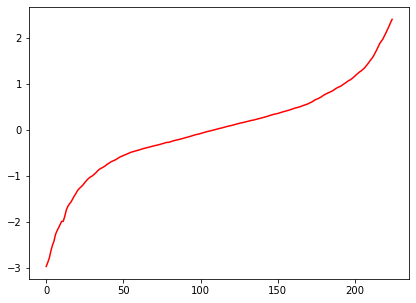

In [189]:
num_state_train = state_train_data[current_state].shape[0]
forecast_range = np.arange(num_state_train, num_state_train+forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data[current_state].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(forecast_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

In [172]:
y_result = np.array(y_result) * state_scaler[current_state].scale_[0] + state_scaler[current_state].mean_[0]

In [173]:
y_result

array([562725.98921931, 567652.84774943, 572585.67132757, 577327.99296288,
       581894.09261881, 586165.82619265, 590200.38584184])

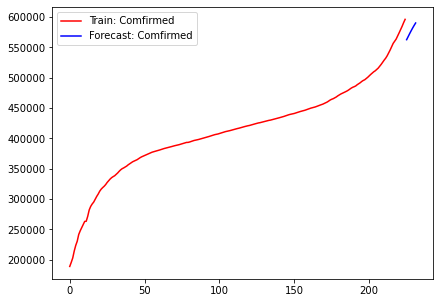

In [174]:
num_state_train = states_data[current_state].shape[0]
validate_range = np.arange(num_state_train, num_state_train+forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(np.arange(num_state_train), states_data[current_state]['Confirmed']* state_scaler[current_state].scale_[0] + state_scaler[current_state].mean_[0], color='red', label='Train: Comfirmed')
plt.plot(validate_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

## Train a RNN with LSTM for Every State

In [24]:
num_states = len(states_data.keys())
initialization = np.zeros((forecast_day*num_states, 3))
result_df = pd.DataFrame(initialization, columns=['ForecastID', 'Confirmed', 'Deaths'], dtype='int')

def forcast(window_size, forecast_day, predict_label):
    predict_index = 0
    if predict_label == 'Deaths':
        predict_index = 1
        
    state_count = 0
    for state in states_data.keys():
        current_state = state
        num_state_train = state_train_data[current_state].shape[0]
        num_state_validate = state_validate_data[current_state].shape[0]
        validate_range = np.arange(num_state_train, num_state_train+num_state_validate)
        data_training = np.array(state_train_data[current_state])

        X_train = []
        y_train = []

        for i in range(window_size, data_training.shape[0]-forecast_day):
            X_train.append(data_training[i-window_size:i])
            y_train.append(data_training[i+forecast_day, predict_index])

        X_train, y_train = np.array(X_train), np.array(y_train)
        model = keras.Sequential()

        model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 200, activation = 'relu'))
        model.add(Dropout(0.2))

        model.add(Dense(units = 1))

        # model.summary()

        model.compile(optimizer='adam', loss = 'mean_squared_error')
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

        previous_days = state_train_data[current_state].tail(window_size+forecast_day)
        inputs = np.array(previous_days)
        X_test = []
        y_test = []

        for i in range(window_size, inputs.shape[0]):
            X_test.append(inputs[i-window_size:i])
            y_test.append(inputs[i,predict_index])

        X_test, y_test = np.array(X_test), np.array(y_test)

        y_pred = model.predict(X_test)
        y_result = y_pred.flatten().tolist()
        y_result = np.array(y_result) * state_scaler[current_state].scale_[predict_index] + state_scaler[current_state].mean_[predict_index]

        date_count = 0
        for r in y_result:
            forecast_id = state_count + date_count * num_states
            result_df.loc[forecast_id]['ForecastID'] = forecast_id;
            result_df.loc[forecast_id][predict_label] = r;
            date_count += 1
        state_count += 1

In [25]:
forcast(7, 7, 'Confirmed')
forcast(7, 7, 'Deaths')

KeyboardInterrupt: 

In [ ]:
result_df.to_csv('./data/submission_round2.csv')